## **Statistical Learning – Data science - 2021/22 – Exercise 3 – 05/04/2022**
# **Exercise 3: Analysis of Prostate Cancer dataset – variable subset selection**

In [1]:
# data analysis and wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import itertools # itertools functions create iterators for efficient looping
                 # itertools.combinations(p,r) creates r-length tuples, in sorted order, no repeated elements
                 # ex. combinations('ABCD', 2) = [AB AC AD BC BD CD]
        

#from IPython.display import Image # to visualize images
#from tabulate import tabulate # to create tables

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/prostate-data/tab4.png
/kaggle/input/prostate-data/tab4-no-cap.png
/kaggle/input/prostate-data/tab3.png
/kaggle/input/prostate-data/prostate.data
/kaggle/input/prostate-data/tab.png
/kaggle/input/prostate-data/tab2.png


## **1. Open your kernel SL_EX2_ProstateCancer_Surname in Kaggle**
> <h2>✅</h2>

## **2. Generate a copy called SL_EX3_SubsetSelection_Surname by the Fork button**
> <h2>✅</h2>

# **Data acquisition**

In [2]:
# Load the Prostate Cancer dataset
data = pd.read_csv('../input/prostate-data/prostate.data',sep='\t')

In [3]:
# Save "train" and lpsa" columns into Pandas Series variables
train = data['train']
lpsa = data['lpsa']

# Drop "train" and lpsa" variable from data
data = data.drop(columns=['Unnamed: 0','lpsa','train'],axis=1)

# **Prepare the data**

In [4]:
## X VARIABLE:
# Split the data in train and test sets
dataTrain = data.loc[train == 'T'] # Obviously, len(idx)==len(dataTrain) is True!
dataTest = data.loc[train == 'F']

# Rename these two variables as "predictorsTrain" and "predictorsTest"
predictorsTrain = dataTrain
predictorsTest = dataTest


## Y VARIABLE:
# Split the "lpsa" in train and test sets
lpsaTrain = lpsa.loc[train == 'T']
lpsaTest = lpsa.loc[train == 'F']

## **Standardization**
$$\dfrac{predictors - predictorsMeans}{predictorsStd}$$

In [5]:
# Standardize "predictorsTrain"
predictorsTrainMeans = predictorsTrain.mean()
predictorsTrainStds = predictorsTrain.std()
predictorsTrain_std = (predictorsTrain - predictorsTrainMeans)/predictorsTrainStds # standardized variables of predictorTrain

# Standardize "predictorsTest" (using the mean and std of predictorsTrain, it's better!)
predictorsTest_std = (predictorsTest - predictorsTrainMeans)/predictorsTrainStds # standardized variables of predictorTest

## **Split into Training and Test sets**

In [6]:
## TRAINING SET
X_train = predictorsTrain_std
Y_train = lpsaTrain

## TEST SET
X_test = predictorsTest_std
Y_test = lpsaTest

# **Useful functions for Linear Regression**

In [7]:
# Useful functions in order to compute RSS, R_squared and Zscore.
def LinReg(X_train,Y_train,X_test,Y_test):
    
    # Create the linear model, fitting also the intecept (non-zero)
    model = LinearRegression(fit_intercept = True)
    
    # Train the model on training set
    model.fit(X_train,Y_train)
    
    # Stats on Training set
    Y_train_pred = model.predict(X_train)
    RSS_train = mean_squared_error(Y_train,Y_train_pred) * len(Y_train)
    R2_train = model.score(X_train,Y_train)
    
    # Stats on Test set
    Y_test_pred = model.predict(X_test)
    RSS_test = mean_squared_error(Y_test,Y_test_pred) * len(Y_test)
    R2_test = model.score(X_test,Y_test)
    
    # other way for R2 on test set
    RMSE_test = (((Y_test_pred-Y_test)**2).mean())**(0.5)
    
    # choose R_squared btw train and test
    R_squared = R2_train

    return RSS_train, RSS_test, R_squared, RMSE_test

def Zscore(X_train,Y_train):
    
    # fitting the model
    model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
    
    Zscores = model.tvalues[1:] # we don't want const
    min_Zscore = min(abs(Zscores))
    idx_min_Zscore = abs(Zscores).idxmin() # it's the nearest to zero, so the variable less significant!

    return Zscores, min_Zscore, idx_min_Zscore

## **Functions to print some info**

In [8]:
## Print information about an iteration forward subset selection with subset size ncomb
# ncomb = number of the iteration
# features = remaining_features, selected_features (used to do the iteration and take track of the selection)
# params = all_RSS, all_R_squared, all_combs
# results = best_RSS, best_feature (results of the selection)
# detailed = parameter to see more detail about each single combination
def get_info_forwardS(ncomb,features,params,results,detailed):
    
    sepComb = "==="*30
    sepIter = "---"*30

    remaining, selected = features
    bestFeat, bestRSS = results
    
    print(f"{sepComb}\nIter n.{ncomb}:\n\
Choose {ncomb}-length combinations of the remaining variables\n\n\
Remaining features: {remaining}\n\
Features selected: {selected}")

    if detailed == 1:
        RSS, R_squared, Combs = params
        
        for niter in range(0,len(Combs)):
            var0 = Combs[niter]
            var1 = RSS[niter] 
            var2 = R_squared[niter]
            print(f"\nComb n.{niter+1}: {var0}\n\
{sepIter}\n\
RSS test: {var1}\n\
R_squared: {var2}\
")
        
    print(f"\nSelected variables: {bestFeat}\n\
min RSS: {bestRSS}\n\
{sepComb}\n")

    return


## Print information about an iteration backward subset selection with subset size ncomb
# ncomb = number of the iteration
# features = [remaining_features,dropped_features_list] (used to do the iteration and take track of the selection)
# params = [all_RSS,all_R_squared,all_combs]
# results = [best_RSS,dropped_feature]
# detailed = parameter to see more detail about each single combination

def get_info_backwardS(ncomb,features,params,results,detailed):
    
    sepComb = "==="*30
    sepIter = "---"*30

    remaining, dropped = features
    droppedFeat, bestRSS = results

    print(f"{sepComb}\nIter n.{8 - ncomb}:\n\n\
At the beginning we have:\n\
Remaining features: {remaining}\n\
Dropped features: {dropped}\n\n\
Now we compare the model selecting {ncomb} variables")

    if detailed == 1:
        RSS, R_squared, Combs = params
        
        for niter in range(0,len(Combs)):
            var0 = Combs[niter]
            var1 = RSS[niter] 
            var2 = R_squared[niter]
            print(f"\n\nComb n.{niter+1}: {var0}\n\
{sepIter}\n\
candidate dropped feature: {list(set(remaining)-set(var0))}\n\
RSS test: {var1}\
")

    print(f"\n\nAt the end we have:\n\
min RSS: {bestRSS}\n\
We drop: {droppedFeat}\n\
{sepComb}\n")
    
    return


## Print information about an iteration backward subset selection with subset size ncomb
# ncomb = number of the iteration
# features = [remaining_features,dropped_features_list] (used to do the iteration and take track of the selection)
# params = [all_RSS,all_R_squared,all_combs]
# results = [best_RSS,dropped_feature]
# detailed = parameter to see more detail about each single combination

def get_info_backwardS_Zscore(ncomb,features,params,results,detailed):
    
    sepComb = "==="*30
    sepIter = "---"*30

    remaining, dropped = features
    droppedFeat, bestRSS = results

    print(f"{sepComb}\nIter n.{8 - ncomb}:\n\n\
At the beginning we have:\n\
Remaining features: {remaining}\n\
Dropped features: {dropped}\n")

    print("\nThe Z-scores are:\n",Zscores)

    print(f"\n\nAt the end we have:\n\
min RSS: {bestRSS}\n\
We drop: {droppedFeat}\n\
{sepComb}\n")
    
    return

# **Best Subset Selection**

## **3. Starting from the `ols models` achieved in the last steps, perform best-subset selection.**
* Generate one model for each combination of the 8 variables available
* For each model compute the RSS on training and test set, the number of variables and the $R^2$ of the model
* Save these numbers in suitable data structures

In [9]:
## range
variables = data.columns.tolist() # excluding 'const'

## Initialize the list where we temporarily store data
RSS_train_list, RSS_test_list, R_squared_list, RMSE_list = [], [], [], []
numb_features, features_list = [], []

for k in range(1,len(variables) + 1):

    niter = 0
    #print("---"*30,f"\nStart by choosing {k} variables\n")
    
    # Looping over all possible combinations of k variables
    for combo in itertools.combinations(variables,k):
        
        niter = niter+1 
        
        # Compute all the statistics we need
        [RSS_train, RSS_test, R2, RMSE_test] = LinReg(X_train[list(combo)], Y_train, X_test[list(combo)], Y_test)
        
        rnd  =4
        #print(f"{niter}. train: {R2_train.round(rnd)}, test: {R2_test.round(rnd)}, rmse test: {RMSE_list.round(rnd)}")
        
        # Save the statistics
        RSS_train_list.append(RSS_train)
        RSS_test_list.append(RSS_test)
        R_squared_list.append(R2)
        RMSE_list.append(RMSE_test)
        
        # Save features and number of features
        features_list.append(combo)
        numb_features.append(len(combo))   

#     print(f"\nUsing {k} variables we have computed {niter} models")
#     print("---"*30,"\n")
    
#Store in DataFrame
df_BestS = pd.DataFrame({'numb_features': numb_features,\
                         'RSS_train': RSS_train_list,\
                         'RSS_test': RSS_test_list,\
                         'R_squared': R_squared_list,\
                         'RMSE_test': RMSE_list,\
                         'features': features_list,\
                         'numb_features': numb_features})

In [10]:
df_BestS

,numb_features,RSS_train,RSS_test,R_squared,RMSE_test,features
0,1,44.528583,14.392162,0.537516,0.692632,"(lcavol,)"
1,1,73.613540,30.402846,0.235434,1.006692,"(lweight,)"
2,1,91.292039,33.846748,0.051821,1.062179,"(age,)"
3,1,89.624912,35.298771,0.069136,1.084724,"(lbph,)"
4,1,66.422403,20.632078,0.310122,0.829298,"(svi,)"
...,...,...,...,...,...,...
250,7,31.570706,14.702112,0.672100,0.700050,"(lcavol, lweight, age, svi, lcp, gleason, pgg45)"
251,7,30.414990,17.034552,0.684103,0.753537,"(lcavol, lweight, lbph, svi, lcp, gleason, pgg45)"
252,7,33.265433,16.754443,0.654498,0.747316,"(lcavol, age, lbph, svi, lcp, gleason, pgg45)"
253,7,44.036622,22.633329,0.542626,0.868588,"(lweight, age, lbph, svi, lcp, gleason, pgg45)"


## **Find the best subset (of variables) for each number of features**
Now our dataframe **`df_BestS`** has a row for each model computed, and it's not easy to handle. For this reason, we extract the best model for each number of variables by observing the interesting parameter.\
We consider as interesting parameter:
1. minimum RSS train
2. minimum RSS test
3. maximum $R^2$

In [11]:
# Create new df, selection only best subsets of variables (based on RSS and R^2)
tmp = df_BestS
df_BestS_RSS_train= tmp[tmp.groupby('numb_features')['RSS_train'].transform(min) == tmp['RSS_train']]
df_BestS_RSS_test = tmp[tmp.groupby('numb_features')['RSS_test'].transform(min) == tmp['RSS_test']]
df_BestS_RMSE_test = tmp[tmp.groupby('numb_features')['RMSE_test'].transform(min) == tmp['RMSE_test']]
df_BestS_R_squared = tmp[tmp.groupby('numb_features')['R_squared'].transform(max) == tmp['R_squared']]

In [12]:
df_BestS_RSS_train

,numb_features,RSS_train,RSS_test,R_squared,RMSE_test,features
0,1,44.528583,14.392162,0.537516,0.692632,"(lcavol,)"
8,2,37.091846,14.774470,0.614756,0.701771,"(lcavol, lweight)"
38,3,34.907749,12.015924,0.637441,0.632875,"(lcavol, lweight, svi)"
97,4,32.814995,13.689964,0.659176,0.675524,"(lcavol, lweight, lbph, svi)"
174,5,32.069447,14.577726,0.666920,0.697083,"(lcavol, lweight, lbph, svi, pgg45)"
229,6,30.539778,16.457800,0.682807,0.740671,"(lcavol, lweight, lbph, svi, lcp, pgg45)"
247,7,29.437300,15.495405,0.694258,0.718689,"(lcavol, lweight, age, lbph, svi, lcp, pgg45)"
254,8,29.426384,15.638220,0.694371,0.721993,"(lcavol, lweight, age, lbph, svi, lcp, gleason..."


In [13]:
df_BestS_RSS_test

,numb_features,RSS_train,RSS_test,R_squared,RMSE_test,features
0,1,44.528583,14.392162,0.537516,0.692632,"(lcavol,)"
11,2,42.312584,11.583584,0.560532,0.621385,"(lcavol, svi)"
52,3,42.267034,11.484038,0.561005,0.618709,"(lcavol, svi, gleason)"
112,4,42.223638,11.612573,0.561456,0.622162,"(lcavol, age, svi, gleason)"
167,5,34.170209,11.497692,0.645101,0.619077,"(lcavol, lweight, age, svi, gleason)"
226,6,33.642783,12.009380,0.650579,0.632703,"(lcavol, lweight, age, svi, gleason, pgg45)"
246,7,30.958630,13.492898,0.678457,0.670644,"(lcavol, lweight, age, lbph, svi, lcp, gleason)"
254,8,29.426384,15.638220,0.694371,0.721993,"(lcavol, lweight, age, lbph, svi, lcp, gleason..."


In [14]:
# the same as selecting min RSS on training set
df_BestS_R_squared

,numb_features,RSS_train,RSS_test,R_squared,RMSE_test,features
0,1,44.528583,14.392162,0.537516,0.692632,"(lcavol,)"
8,2,37.091846,14.774470,0.614756,0.701771,"(lcavol, lweight)"
38,3,34.907749,12.015924,0.637441,0.632875,"(lcavol, lweight, svi)"
97,4,32.814995,13.689964,0.659176,0.675524,"(lcavol, lweight, lbph, svi)"
174,5,32.069447,14.577726,0.666920,0.697083,"(lcavol, lweight, lbph, svi, pgg45)"
229,6,30.539778,16.457800,0.682807,0.740671,"(lcavol, lweight, lbph, svi, lcp, pgg45)"
247,7,29.437300,15.495405,0.694258,0.718689,"(lcavol, lweight, age, lbph, svi, lcp, pgg45)"
254,8,29.426384,15.638220,0.694371,0.721993,"(lcavol, lweight, age, lbph, svi, lcp, gleason..."


# **Plots for Best Selection**

## **4. + 5. + 6.  Generate some charts:**
    - x-axis: the subset size
    - y-axis:
        * 4. RSS for training set of all the models generated at step 3
        * 5. $R^2$ of all the models generated at step 3 (ndr, we choose to compute it on training set)
        * 6. RSS for test set of all the models generated at step 3

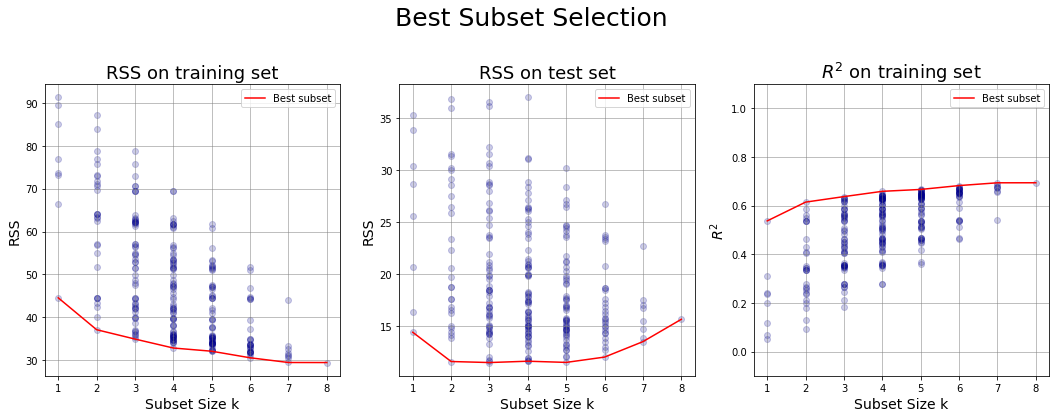

In [15]:
# Initialize the figure
width = 6
height = 6
nfig = 3
fig = plt.figure(figsize = (width*nfig,height))

# 1. RSS Training set plot
tmp_df1 = df_BestS;           # scatter plot
tmp_df2 = df_BestS_RSS_train; # plot the line of best values
ax1 = fig.add_subplot(1, nfig, 1)
ax1.scatter(tmp_df1.numb_features,tmp_df1.RSS_train, alpha = .2, color = 'darkblue');
ax1.set_xlabel('Subset Size k',fontsize=14);
ax1.set_ylabel('RSS',fontsize=14);
ax1.set_title('RSS on training set',fontsize=18);
ax1.plot(tmp_df2.numb_features,tmp_df2.RSS_train,color = 'r', label = 'Best subset'); # line of best values
ax1.grid(color='grey', linestyle='-', linewidth=0.5);
ax1.legend();

# 2. RSS Test set plot
tmp_df1 = df_BestS;           # scatter plot
tmp_df2 = df_BestS_RSS_test;  # plot the line of best values
ax2 = fig.add_subplot(1, nfig, 2);
ax2.scatter(tmp_df1.numb_features,tmp_df1.RSS_test, alpha = .2, color = 'darkblue');
ax2.set_xlabel('Subset Size k',fontsize=14);
ax2.set_ylabel('RSS',fontsize=14);
ax2.set_title('RSS on test set',fontsize=18);
ax2.plot(tmp_df2.numb_features,tmp_df2.RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax2.grid(color='grey', linestyle='-', linewidth=0.5);
ax2.legend();

# 3. R^2 plot
tmp_df1 = df_BestS;           # scatter plot
tmp_df2 = df_BestS_R_squared;  # plot the line of best values
ax3 = fig.add_subplot(1, nfig, 3);
ax3.scatter(tmp_df1.numb_features,tmp_df1.R_squared, alpha = .2, color = 'darkblue');
ax3.set_xlabel('Subset Size k',fontsize=14);
ax3.set_ylabel('$R^2$',fontsize=14);
ax3.set_ylim(bottom=-0.1,top=1.1)
ax3.set_title('$R^2$ on training set',fontsize=18);
ax3.plot(tmp_df2.numb_features,tmp_df2.R_squared,color = 'r', label = 'Best subset'); # line of best values
ax3.grid(color='grey', linestyle='-', linewidth=0.5);
ax3.legend();

fig.suptitle('Best Subset Selection',fontsize=25, y=0.98);
fig.subplots_adjust(top=0.8)
plt.show();

## **Comparison RSS and RMSE on test set: same stat**
(RMSE is just a rescaling of RSS...)

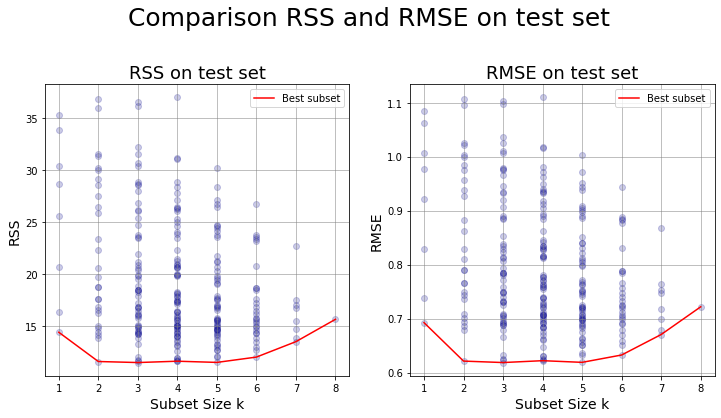

In [16]:
# Initialize the figure
width = 6
height = 6
nfig = 2
fig = plt.figure(figsize = (width*nfig,height))

# 1. RSS Test set plot
tmp_df1 = df_BestS;           # scatter plot
tmp_df2 = df_BestS_RSS_test;  # plot the line of best values
ax1 = fig.add_subplot(1, nfig, 1);
ax1.scatter(tmp_df1.numb_features,tmp_df1.RSS_test, alpha = .2, color = 'darkblue');
ax1.set_xlabel('Subset Size k',fontsize=14);
ax1.set_ylabel('RSS',fontsize=14);
ax1.set_title('RSS on test set',fontsize=18);
ax1.plot(tmp_df2.numb_features,tmp_df2.RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax1.grid(color='grey', linestyle='-', linewidth=0.5);
ax1.legend();

# 2. RMSE Test set plot
tmp_df1 = df_BestS;           # scatter plot
tmp_df2 = df_BestS_RMSE_test;  # plot the line of best values
ax2 = fig.add_subplot(1, nfig, 2);
ax2.scatter(tmp_df1.numb_features,tmp_df1.RMSE_test, alpha = .2, color = 'darkblue');
ax2.set_xlabel('Subset Size k',fontsize=14);
ax2.set_ylabel('RMSE',fontsize=14);
ax2.set_title('RMSE on test set',fontsize=18);
ax2.plot(tmp_df2.numb_features,tmp_df2.RMSE_test,color = 'r', label = 'Best subset'); # line of best values
ax2.grid(color='grey', linestyle='-', linewidth=0.5);
ax2.legend();

fig.suptitle('Comparison RSS and RMSE on test set',fontsize=25, y=0.98);
fig.subplots_adjust(top=0.8)

plt.show();

# **Forward selection**

For computational reasons, the best subset cannot be applied for any large n due to the $2^n$ complexity.\
Forward Stepwise begins with a model containing no predictors, and then adds predictors to the model, one at the time. At each step, the variable that gives the greatest additional improvement to the fit is added to the model.

## **7. Perform forward selection**
* Start from the empty model
* Add at each step the variable that **minimizes the RSS computed on test set** (other performance measures can be used)

In [17]:
# to print some info:
flag = 1
detailed = 1

In [18]:
## range
variables = data.columns.tolist()
remaining_features, selected_features = variables.copy(), []

## Initialize the list where we temporarilstore data
RSS_test_list, min_RSS_test_list, R_squared_list = [], [], []
numb_features, features_list = [], []

# Loop over the number of variables
for k in range(1,len(variables)+1):
    
    # store some info for each k
    all_RSS, all_R_squared, all_combs = [],[], []
    best_RSS = np.inf # initialize the best RSS as +inf

    # choose one variable in the remaining features
    for var in remaining_features:
        
        tmpComb = selected_features + [var]; # combination of variables
        
        # Compute all the statistics we need
        _, RSS_test, R_squared,_ = LinReg(X_train[tmpComb], Y_train, X_test[tmpComb], Y_test) # we don't want RSS on training set
        
        # save temporary stats
        all_RSS.append(RSS_test)
        all_R_squared.append(R_squared)
        all_combs.append(tmpComb)

        # update if we reach a better RSS
        if RSS_test < best_RSS:
            best_RSS = RSS_test
            best_R_squared = R_squared
            best_feature = var
   
    # Print some information, before upgrading the features
    if flag == 1:
        features = [remaining_features,selected_features]
        params = [all_RSS,all_R_squared,all_combs]
        results = [best_RSS,best_feature]
        get_info_forwardS(k,features,params,results,detailed)
        
    # Save the statistics
    RSS_test_list.append(all_RSS)
    min_RSS_test_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    
    # Update variables for next loop
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)

    # Save features and number of features
    features_list.append(selected_features.copy())
    numb_features.append(len(selected_features))
    
# Store in DataFrame
df_ForwardS = pd.DataFrame({'numb_features': numb_features,\
                            'RSS_test' : RSS_test_list,\
                            'min_RSS_test': min_RSS_test_list,\
                            'R_squared': R_squared_list,\
                            'features': features_list})

Iter n.1:
Choose 1-length combinations of the remaining variables

Remaining features: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
Features selected: []

Comb n.1: ['lcavol']
------------------------------------------------------------------------------------------
RSS test: 14.392161587304827
R_squared: 0.5375164690552883

Comb n.2: ['lweight']
------------------------------------------------------------------------------------------
RSS test: 30.402845602615997
R_squared: 0.23543378299009432

Comb n.3: ['age']
------------------------------------------------------------------------------------------
RSS test: 33.846748424133
R_squared: 0.05182105437299367

Comb n.4: ['lbph']
------------------------------------------------------------------------------------------
RSS test: 35.29877101280492
R_squared: 0.06913619684911343

Comb n.5: ['svi']
------------------------------------------------------------------------------------------
RSS test: 20.63207813987685

In [19]:
# look at the result
df_ForwardS

,numb_features,RSS_test,min_RSS_test,R_squared,features
0,1,"[14.392161587304827, 30.402845602615997, 33.84...",14.392162,0.537516,[lcavol]
1,2,"[14.77447043041511, 14.454316401468965, 16.237...",11.583584,0.560532,"[lcavol, svi]"
2,3,"[12.015924403078804, 11.71416952499475, 14.353...",11.484038,0.561005,"[lcavol, svi, gleason]"
3,4,"[11.95602065641986, 11.612572746859495, 14.355...",11.612573,0.561456,"[lcavol, svi, gleason, age]"
4,5,"[11.497691985782547, 13.947298386201728, 13.23...",11.497692,0.645101,"[lcavol, svi, gleason, age, lweight]"
5,6,"[12.98960324749752, 12.690514046312407, 12.009...",12.009380,0.650579,"[lcavol, svi, gleason, age, lweight, pgg45]"
6,7,"[13.834231490831279, 14.702111705571856]",13.834231,0.676005,"[lcavol, svi, gleason, age, lweight, pgg45, lbph]"
7,8,[15.638220165228002],15.638220,0.694371,"[lcavol, svi, gleason, age, lweight, pgg45, lb..."


# **Plot for Forward Selection**

## **8. Generate a chart having:**
    - x-axis: the subset size
    - y-axis: the RSS for the test set of the models generated at step 7

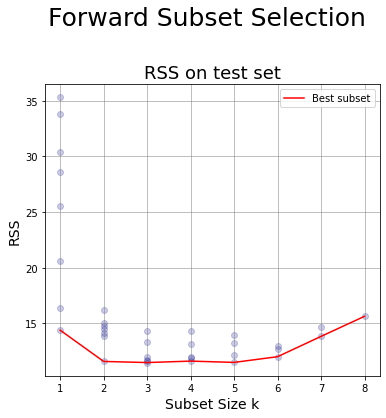

In [20]:
# Initialize the figure
width = 6
height = 6
nfig = 1
fig = plt.figure(figsize = (width*nfig,height))

# 1. RSS Test set plot
tmp_df = df_ForwardS;
ax = fig.add_subplot(1, nfig, 1)
for i in range(0,len(tmp_df.RSS_test)):
    ax.scatter([tmp_df.numb_features[i]]*(len(tmp_df.RSS_test[i])),tmp_df.RSS_test[i], alpha = .2, color = 'darkblue');
    
ax.set_xlabel('Subset Size k',fontsize=14);
ax.set_ylabel('RSS',fontsize=14);
ax.set_title('RSS on test set',fontsize=18);
ax.plot(tmp_df.numb_features,tmp_df.min_RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.legend();

fig.suptitle('Forward Subset Selection',fontsize=25, y=0.98);
fig.subplots_adjust(top=0.8)
plt.show()

# **Backward selection**

Another alternative to best subset selection is Backward Stepwise Selection.\
Backward Stepwise begins with a model containing all the predictors, and then removes predictors to the model, one at the time. At each step, the variable that gives the least improvement to the fit is removed to the model.

Backward selection requires that the **number of samples $n$ is larger than the number of variables $p$**. Instead, Forward selection can be used evene $n<p$.

## **9. Perform backward selection**
* Start from the full model
* Remove at each step the variable that minimizes the RSS (other performance measures can be used)

In [21]:
# a flag to print some info, values {0,1}
flag = 1     # for short info
detailed = 1

In [22]:
## range
variables = data.columns.tolist()         # excluding 'const', fixed iterator
remaining_features, dropped_features_list = variables.copy(), []

## Initialize the list where we temporarily store data
RSS_test_list, min_RSS_test_list, R_squared_list = [], [], []
numb_features, features_list = [], []

# run over the number of variables
for k in range(len(variables),0,-1):

    # initialization
    best_RSS = np.inf
    all_RSS, all_R_squared, all_combs = [],[], []

    for combo in itertools.combinations(remaining_features,k):

        # Compute the stats we need
        tmpComb = list(combo)
        _, RSS_test, R_squared, _ = LinReg(X_train[tmpComb], Y_train, X_test[tmpComb], Y_test) # we don't want RSS on training set
        
        # store all the RSS
        all_RSS.append(RSS_test)
        all_R_squared.append(R_squared)
        all_combs.append(tmpComb)
        
        if RSS_test < best_RSS:
            best_RSS = RSS_test
            best_R_squared = R_squared
            dropped_list = list(set(remaining_features)-set(tmpComb))
 
    # Print some information, before upgrading the features
    if flag == 1:
        features = [remaining_features,dropped_features_list]
        params = [all_RSS,all_R_squared,all_combs]
        if dropped_list: # only if dropped_feature is not an empty list
            dropped_feature = dropped_list[0]
            results = [best_RSS,dropped_feature]
        else:
            results = [best_RSS,[]]
            
        get_info_backwardS(k,features,params,results,detailed)
        
    # Updating variables for next loop
    if dropped_list: # only if dropped_feature is not an empty list
        dropped_feature = dropped_list[0]
        remaining_features.remove(dropped_feature)
        dropped_features_list.append(dropped_feature)
    else:
        dropped_features_list.append([]) # at the initial iteration we drop nothing!
        
    # Save stats
    min_RSS_test_list.append(best_RSS)
    RSS_test_list.append(all_RSS.copy())
    R_squared_list.append(best_R_squared.copy())

    # Save features and number of features
    numb_features.append(len(remaining_features))
    features_list.append(remaining_features.copy())
    
# Store in DataFrame
df_BackwardS = pd.DataFrame({'numb_features': numb_features,\
                             'RSS_test' : RSS_test_list,\
                             'min_RSS_test': min_RSS_test_list,\
                             'R_squared': R_squared_list,\
                             'dropped_feature': dropped_features_list,\
                             'features': features_list})

Iter n.0:

At the beginning we have:
Remaining features: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
Dropped features: []

Now we compare the model selecting 8 variables


Comb n.1: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
------------------------------------------------------------------------------------------
candidate dropped feature: []
RSS test: 15.638220165228002


At the end we have:
min RSS: []
We drop: 15.638220165228002

Iter n.1:

At the beginning we have:
Remaining features: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
Dropped features: [[]]

Now we compare the model selecting 7 variables


Comb n.1: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason']
------------------------------------------------------------------------------------------
candidate dropped feature: ['pgg45']
RSS test: 13.492898446056923


Comb n.2: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45']
-----

In [23]:
# look at the result
df_BackwardS

,numb_features,RSS_test,min_RSS_test,R_squared,dropped_feature,features
0,8,[15.638220165228002],15.638220,0.694371,[],"[lcavol, lweight, age, lbph, svi, lcp, gleason..."
1,7,"[13.492898446056923, 15.495404626758, 13.83423...",13.492898,0.678457,pgg45,"[lcavol, lweight, age, lbph, svi, lcp, gleason]"
2,6,"[13.43573406046562, 12.98960324749752, 15.2446...",12.690514,0.656353,lbph,"[lcavol, lweight, age, svi, lcp, gleason]"
3,5,"[12.70021855056121, 11.497691985782552, 14.720...",11.497692,0.645101,lcp,"[lcavol, lweight, age, svi, gleason]"
4,4,"[11.6363032699816, 14.030539349222018, 11.9560...",11.612573,0.561456,lweight,"[lcavol, age, svi, gleason]"
5,3,"[11.71416952499475, 14.18793001209106, 11.4840...",11.484038,0.561005,age,"[lcavol, svi, gleason]"
6,2,"[11.58358360007023, 14.140851461764317, 18.710...",11.583584,0.560532,gleason,"[lcavol, svi]"
7,1,"[14.392161587304827, 20.632078139876853]",14.392162,0.537516,svi,[lcavol]


# **Plot for Backward Selection**

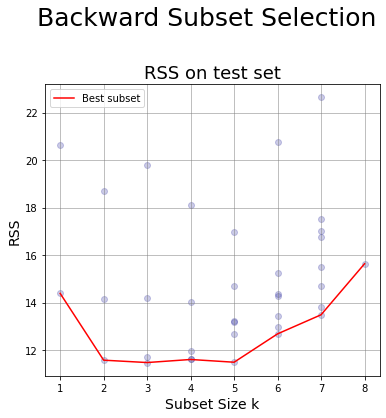

In [24]:
# Initialize the figure
width = 6
height = 6
nfig = 1
fig = plt.figure(figsize = (width*nfig,height))

# 1. RSS Test set plot
tmp_df = df_BackwardS;
ax = fig.add_subplot(1, nfig, 1)
for i in range(0,len(tmp_df.RSS_test)):
    ax.scatter([tmp_df.numb_features[i]]*(len(tmp_df.RSS_test[i])),tmp_df.RSS_test[i], alpha = .2, color = 'darkblue');
    
ax.set_xlabel('Subset Size k',fontsize=14);
ax.set_ylabel('RSS',fontsize=14);
ax.set_title('RSS on test set',fontsize=18);
ax.plot(tmp_df.numb_features,tmp_df.min_RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.legend();

fig.suptitle('Backward Subset Selection',fontsize=25, y=0.98);
fig.subplots_adjust(top=0.8)
plt.show()

# **Results: comparison Subset selction**
Comparison between Best, Forward and Backward Selction results on test set

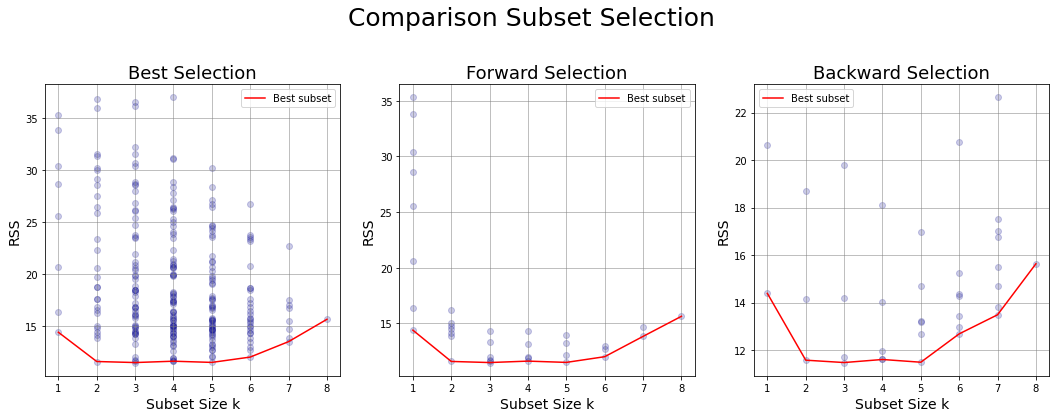

In [25]:
# Initialize the figure
width = 6
height = 6
nfig = 3
fig = plt.figure(figsize = (width*nfig,height))

# 1. BEST SUBSET SELECTION
tmp_df1 = df_BestS;           # scatter plot
tmp_df2 = df_BestS_RSS_test; # plot the line of best values
ax = fig.add_subplot(1, nfig, 1)
ax.scatter(tmp_df1.numb_features,tmp_df1.RSS_test, alpha = .2, color = 'darkblue');
ax.set_xlabel('Subset Size k',fontsize=14);
ax.set_ylabel('RSS',fontsize=14);
ax.set_title('Best Selection',fontsize=18);
ax.plot(tmp_df2.numb_features,tmp_df2.RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.legend();

# 2. FORWARD SUBSET SELECTION
tmp_df = df_ForwardS;
ax = fig.add_subplot(1, nfig, 2)
for i in range(0,len(tmp_df.RSS_test)):
    ax.scatter([tmp_df.numb_features[i]]*(len(tmp_df.RSS_test[i])),tmp_df.RSS_test[i], alpha = .2, color = 'darkblue');
    
ax.set_xlabel('Subset Size k',fontsize=14);
ax.set_ylabel('RSS',fontsize=14);
ax.set_title('Forward Selection',fontsize=18);
ax.plot(tmp_df.numb_features,tmp_df.min_RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.legend();

# 3. BACKWARD SUBSET SELECTION
tmp_df = df_BackwardS;
ax = fig.add_subplot(1, nfig, 3)
for i in range(0,len(tmp_df.RSS_test)):
    ax.scatter([tmp_df.numb_features[i]]*(len(tmp_df.RSS_test[i])),tmp_df.RSS_test[i], alpha = .2, color = 'darkblue');
    
ax.set_xlabel('Subset Size k',fontsize=14);
ax.set_ylabel('RSS',fontsize=14);
ax.set_title('Backward Selection',fontsize=18);
ax.plot(tmp_df.numb_features,tmp_df.min_RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.legend();

fig.suptitle('Comparison Subset Selection',fontsize=25, y=0.98);
fig.subplots_adjust(top=0.8)
plt.show()

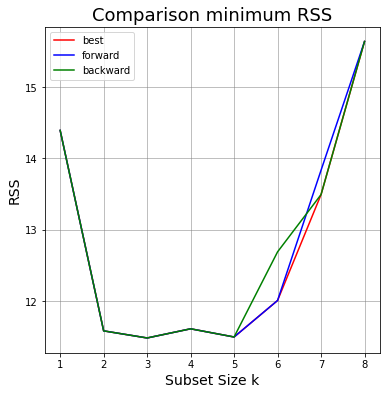

In [26]:
# Initialize the figure
width = 6
height = 6
nfig = 1
fig = plt.figure(figsize = (width*nfig,height))
ax = fig.add_subplot(1, nfig, 1)

# Best Selection
ax.plot(df_BestS_RSS_test.numb_features,df_BestS_RSS_test.RSS_test,color = 'r', label = 'Best subset'); # line of best values

# Forward Selection
ax.plot(df_ForwardS.numb_features,df_ForwardS.min_RSS_test,color = 'b', label = 'Best subset'); # line of best values

# Backward Selection
ax.plot(df_BackwardS.numb_features,df_BackwardS.min_RSS_test,color = 'g', label = 'Best subset'); # line of best values

ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.set_xlabel('Subset Size k',fontsize=14);
ax.set_ylabel('RSS',fontsize=14);
ax.set_title('Comparison minimum RSS',fontsize=18);
ax.legend(['best','forward','backward'])
    
plt.show();

## **Best method from Subset Selection**

We see below the results of Best, Forward and Backward Subset Selection.

In [27]:
df_range = [df_BestS_RSS_test, df_ForwardS, df_BackwardS]
columns_range = ['RSS_test','min_RSS_test','min_RSS_test']
methods = ['Best Selection', 'Forward Selection', 'Backward Selection']

for df, col, meth in zip(df_range,columns_range,methods):
    
    idx = df[col].idxmin()

    print(f"\nFor {meth} the best method has:\n\
n. features: {df['numb_features'][idx]}\n\
features: {df['features'][idx]}\n\
RSS test: {df[col][idx]}\n")


For Best Selection the best method has:
n. features: 3
features: ('lcavol', 'svi', 'gleason')
RSS test: 11.484037587414818


For Forward Selection the best method has:
n. features: 3
features: ['lcavol', 'svi', 'gleason']
RSS test: 11.484037587414818


For Backward Selection the best method has:
n. features: 3
features: ['lcavol', 'svi', 'gleason']
RSS test: 11.484037587414818



## **11. Perform backward selection using the z-score as a statistics for selecting the predictor to drop**
    * Start from the full model
    * Remove at each step the variable having the smallest Z-score (which library is more suitable for this purpose?)

In [28]:
# a flag to print some info, values {0,1}
flag = 1     # for short info

In [29]:
## range
variables = data.columns.tolist()         # excluding 'const', fixed iterator
remaining_features = variables.copy()
tmpComb = remaining_features.copy()
dropped_features_list= []

## Initialize the list where we temporarily store data
RSS_test_list, R_squared_list = [], []
numb_features, features_list = [], []

# Loop over the number of variables
for k in range(len(variables),0,-1):

    # Compute the stats we need
    Zscores, minZ, idx_minZ = Zscore(X_train[tmpComb],Y_train)
    _, RSS_test, R_squared, _ = LinReg(X_train[tmpComb], Y_train, X_test[tmpComb], Y_test)
  
    # Save stats
    RSS_test_list.append(RSS_test)
    R_squared_list.append(best_R_squared.copy())
    
    # Print some information, before upgrading the features
    if flag == 1:
        features = [remaining_features,dropped_features_list]
        params = [RSS_test,R_squared_list,tmpComb]
        if dropped_list: # only if dropped_feature is not an empty list
            dropped_feature = dropped_list[0]
            results = [RSS_test,idx_minZ]
        else:
            results = [RSS_test,[]]
            
        get_info_backwardS_Zscore(k,features,params,results,detailed)
        
    # Save features and number of features
    numb_features.append(k)
    features_list.append(tmpComb.copy())
    
    # update combinations
    tmpComb.remove(idx_minZ)
    dropped_list = list(set(remaining_features)-set(tmpComb))

    # Updating variables for next loop
    if dropped_list: # only if dropped_feature is not an empty list
        dropped_feature = dropped_list[0]
        remaining_features.remove(dropped_feature)
        dropped_features_list.append(dropped_feature)
    else:
        dropped_features_list.append([]) # at the initial iteration we drop nothing!
 
       
# Store in DataFrame
df_BackwardS_minZ = pd.DataFrame({'numb_features': numb_features,\
                             'RSS_test' : RSS_test_list,\
                             'R_squared': R_squared_list,\
                             'dropped_feature': dropped_features_list,\
                             'features': features_list})

Iter n.0:

At the beginning we have:
Remaining features: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
Dropped features: []


The Z-scores are:
 lcavol     5.366290
lweight    2.750789
age       -1.395909
lbph       2.055846
svi        2.469255
lcp       -1.866913
gleason   -0.146681
pgg45      1.737840
dtype: float64


At the end we have:
min RSS: gleason
We drop: 15.638220165228002

Iter n.1:

At the beginning we have:
Remaining features: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45']
Dropped features: ['gleason']


The Z-scores are:
 lcavol     5.462426
lweight    2.833132
age       -1.486490
lbph       2.068796
svi        2.519204
lcp       -1.877253
pgg45      2.182013
dtype: float64


At the end we have:
min RSS: age
We drop: 15.495404626758

Iter n.2:

At the beginning we have:
Remaining features: ['lcavol', 'lweight', 'lbph', 'svi', 'lcp', 'pgg45']
Dropped features: ['gleason', 'age']


The Z-scores are:
 lcavol     5.243670
lweight    2.58

In [30]:
df_BackwardS_minZ

,numb_features,RSS_test,R_squared,dropped_feature,features
0,8,15.638220,0.537516,gleason,"[lcavol, lweight, age, lbph, svi, lcp, gleason..."
1,7,15.495405,0.537516,age,"[lcavol, lweight, age, lbph, svi, lcp, pgg45]"
2,6,16.457800,0.537516,lcp,"[lcavol, lweight, lbph, svi, lcp, pgg45]"
3,5,14.577726,0.537516,pgg45,"[lcavol, lweight, lbph, svi, pgg45]"
4,4,13.689964,0.537516,lbph,"[lcavol, lweight, lbph, svi]"
5,3,12.015924,0.537516,svi,"[lcavol, lweight, svi]"
6,2,14.774470,0.537516,lweight,"[lcavol, lweight]"
7,1,14.392162,0.537516,lcavol,[lcavol]


## **12. Generate a chart having**
        * x-axis: the subset size
        * y-axis: the RSS for the test set of the models generated at step 11
    * Compare it with the chart generated at point 10.

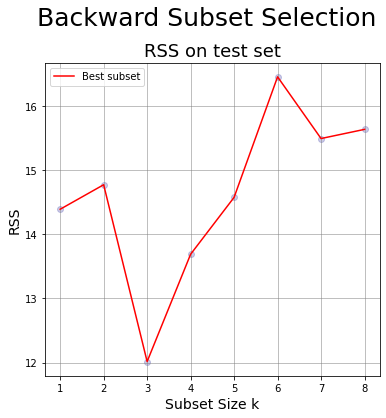

In [31]:
# Initialize the figure
width = 6
height = 6
nfig = 1
fig = plt.figure(figsize = (width*nfig,height))

# 1. RSS Test set plot
tmp_df = df_BackwardS_minZ;
ax = fig.add_subplot(1, nfig, 1)
ax.scatter(tmp_df.numb_features,tmp_df.RSS_test, alpha = .2, color = 'darkblue');
    
ax.set_xlabel('Subset Size k',fontsize=14);
ax.set_ylabel('RSS',fontsize=14);
ax.set_title('RSS on test set',fontsize=18);
ax.plot(tmp_df.numb_features,tmp_df.RSS_test,color = 'r', label = 'Best subset'); # line of best values
ax.grid(color='grey', linestyle='-', linewidth=0.5);
ax.legend();

fig.suptitle('Backward Subset Selection',fontsize=25, y=0.98);
fig.subplots_adjust(top=0.85)
plt.show()

# **Results, comparing with Z-score**:

Now compare the results by choosing the best model not by minimizing RSS but maximizing Zscore.

In [32]:
df_range = [df_BestS_RSS_test, df_ForwardS, df_BackwardS, df_BackwardS_minZ]
columns_range = ['RSS_test','min_RSS_test','min_RSS_test','RSS_test']
methods = ['Best Selection - RSS test', 'Forward Selection - RSS test', 'Backward Selection - RSS test', 'Backward Selection - Z score']

for df, col, meth in zip(df_range,columns_range,methods):
    
    idx = df[col].idxmin()

    print(f"\nFor {meth}, the best method has:\n\
n. features: {df['numb_features'][idx]}\n\
features: {df['features'][idx]}\n\
RSS test: {df[col][idx]}\n")


For Best Selection - RSS test, the best method has:
n. features: 3
features: ('lcavol', 'svi', 'gleason')
RSS test: 11.484037587414818


For Forward Selection - RSS test, the best method has:
n. features: 3
features: ['lcavol', 'svi', 'gleason']
RSS test: 11.484037587414818


For Backward Selection - RSS test, the best method has:
n. features: 3
features: ['lcavol', 'svi', 'gleason']
RSS test: 11.484037587414818


For Backward Selection - Z score, the best method has:
n. features: 3
features: ['lcavol', 'lweight', 'svi']
RSS test: 12.015924403078804

